# Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
import yaml
import monai.networks.nets
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ResizeD,
    LoadImage,
    Rotate,
    Randomizable,
    Transform,
)
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, ThreadDataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from aim.pytorch import track_gradients_dists, track_params_dists
from matplotlib.widgets import Button, Slider

# Test data inference

2024-04-04 15:14:23,852 INFO image_writer.py:197 - writing: out/cropped filtered_Hmox1_CR10285_E185_female_control_homozygote_d6c733f5a9a42ec0a31aecafaf40f793_RH/cropped filtered_Hmox1_CR10285_E185_female_control_homozygote_d6c733f5a9a42ec0a31aecafaf40f793_RH_seg.nii.gz


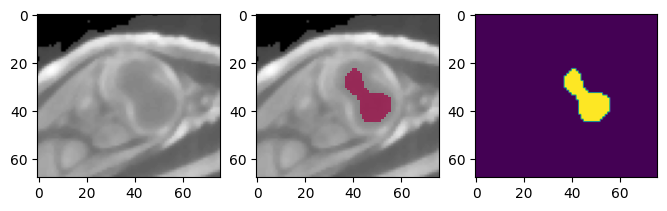

2024-04-04 15:14:24,340 INFO image_writer.py:197 - writing: out/cropped filtered_Hnrnpab_HNRBB_E185_male_control_homozygote_3c05ff5f30297e8cf518a8cb0a5f2c8c_RH/cropped filtered_Hnrnpab_HNRBB_E185_male_control_homozygote_3c05ff5f30297e8cf518a8cb0a5f2c8c_RH_seg.nii.gz


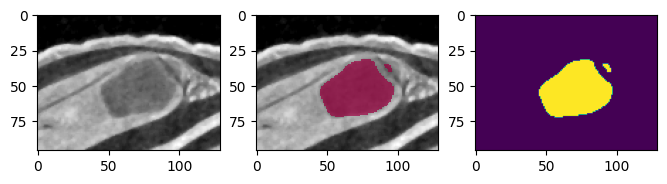

2024-04-04 15:14:24,784 INFO image_writer.py:197 - writing: out/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_LH/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_LH_seg.nii.gz


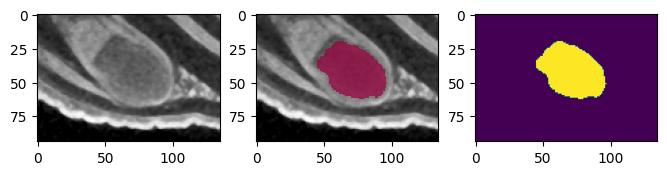

2024-04-04 15:14:25,336 INFO image_writer.py:197 - writing: out/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_3b22b8b8c45e204e300a45f8c6a1a28b_RH_seg.nii.gz


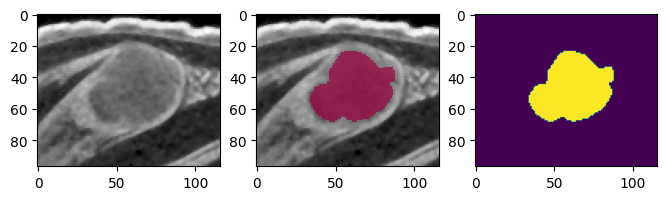

2024-04-04 15:14:25,800 INFO image_writer.py:197 - writing: out/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_cabd954e6abbff49ea11e73076488b23_RH/cropped filtered_Hoxb13_HOXDB_E185_male_control_homozygote_cabd954e6abbff49ea11e73076488b23_RH_seg.nii.gz


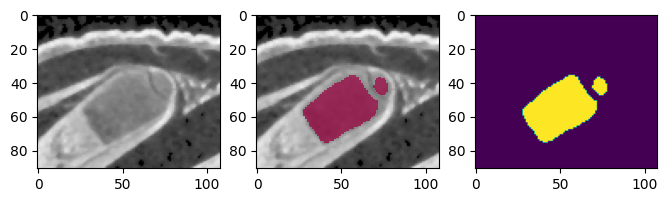

2024-04-04 15:14:26,350 INFO image_writer.py:197 - writing: out/cropped filtered_Hpdl_CR10739_E185_male_control_homozygote_bd27835d8438f541df294911c76da758_RH/cropped filtered_Hpdl_CR10739_E185_male_control_homozygote_bd27835d8438f541df294911c76da758_RH_seg.nii.gz


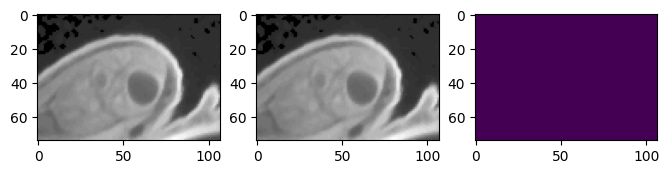

2024-04-04 15:14:26,890 INFO image_writer.py:197 - writing: out/cropped filtered_Katnal1_TCPR1557_AEOB_E185_female_control_homozygote_4d3347b4723534852dc2e823ef21d9b7_RH/cropped filtered_Katnal1_TCPR1557_AEOB_E185_female_control_homozygote_4d3347b4723534852dc2e823ef21d9b7_RH_seg.nii.gz


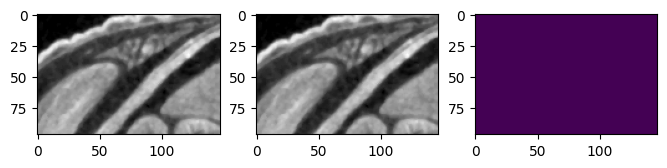

2024-04-04 15:14:27,448 INFO image_writer.py:197 - writing: out/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_LH_seg.nii.gz


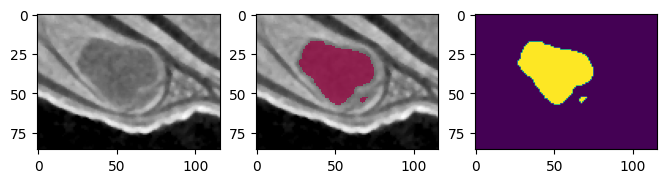

2024-04-04 15:14:27,963 INFO image_writer.py:197 - writing: out/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_RH/cropped filtered_Kcnj13_KCNHB_E185_female_experimental_homozygote_3a364a4b9fc32ffd3455d9bcb69646f1_RH_seg.nii.gz


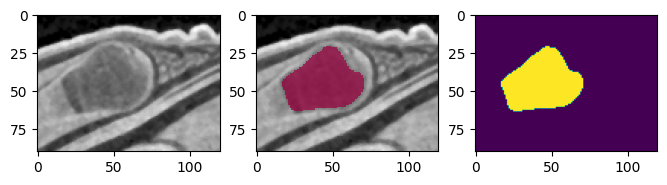

2024-04-04 15:14:28,529 INFO image_writer.py:197 - writing: out/cropped filtered_Kcnj13_KCNHB_E185_male_control_homozygote_e07064b7d6b6262896e77382bb5682cd_RH/cropped filtered_Kcnj13_KCNHB_E185_male_control_homozygote_e07064b7d6b6262896e77382bb5682cd_RH_seg.nii.gz


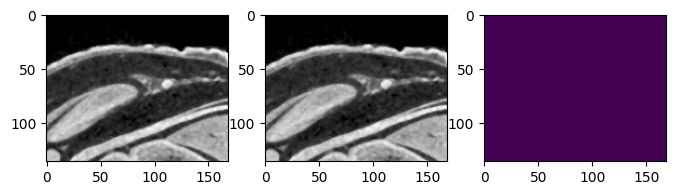

2024-04-04 15:14:29,152 INFO image_writer.py:197 - writing: out/cropped filtered_Kpna2_CR1354_E185_female_control_homozygote_725a4bee8e823ca166909d6c03b2381a_RH/cropped filtered_Kpna2_CR1354_E185_female_control_homozygote_725a4bee8e823ca166909d6c03b2381a_RH_seg.nii.gz


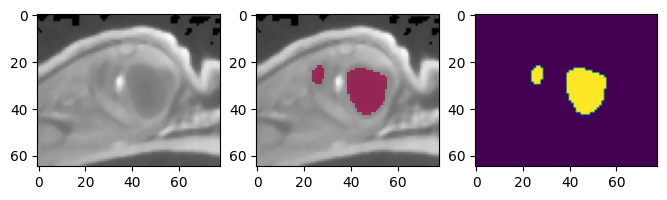

2024-04-04 15:14:29,596 INFO image_writer.py:197 - writing: out/cropped filtered_Lmod3_CR1479_E185_male_control_homozygote_91b105b61ec91d612b6443591214eb90_RH/cropped filtered_Lmod3_CR1479_E185_male_control_homozygote_91b105b61ec91d612b6443591214eb90_RH_seg.nii.gz


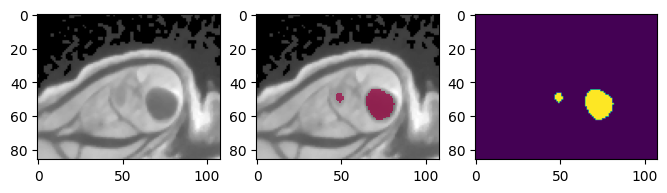

2024-04-04 15:14:30,292 INFO image_writer.py:197 - writing: out/cropped filtered_Map3k12_MAZAB_E185_female_control_homozygote_2667ebb7986efb9d01c4b9e99d6e8e14_RH/cropped filtered_Map3k12_MAZAB_E185_female_control_homozygote_2667ebb7986efb9d01c4b9e99d6e8e14_RH_seg.nii.gz


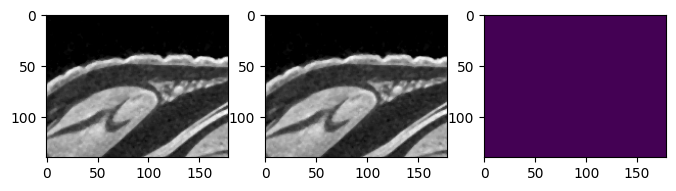

2024-04-04 15:14:31,032 INFO image_writer.py:197 - writing: out/cropped filtered_Nxn_NCXNB_E185_female_control_homozygote_5ab17403a4b5f4e0126efcef31ed575c_RH/cropped filtered_Nxn_NCXNB_E185_female_control_homozygote_5ab17403a4b5f4e0126efcef31ed575c_RH_seg.nii.gz


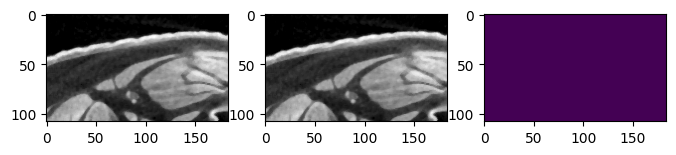

2024-04-04 15:14:31,649 INFO image_writer.py:197 - writing: out/cropped filtered_Nxn_NCXNB_E185_female_control_homozygote_b2f250a910aac7f63ac7874cf69c68c3_RH/cropped filtered_Nxn_NCXNB_E185_female_control_homozygote_b2f250a910aac7f63ac7874cf69c68c3_RH_seg.nii.gz


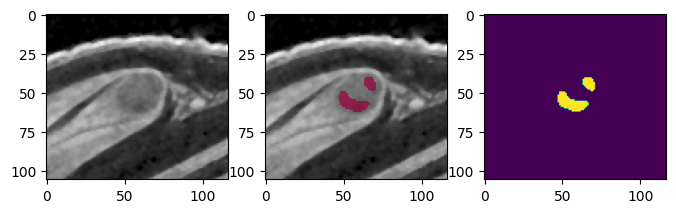

2024-04-04 15:14:32,082 INFO image_writer.py:197 - writing: out/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_3cb3f0331d9ebde4a78c15d290a3c9ca_RH/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_3cb3f0331d9ebde4a78c15d290a3c9ca_RH_seg.nii.gz


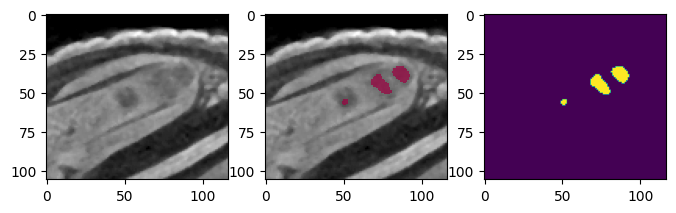

2024-04-04 15:14:32,581 INFO image_writer.py:197 - writing: out/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_671f6a8121231dfb31e88c4b276d8a13_RH/cropped filtered_Odad1_CDOFB_E185_female_control_homozygote_671f6a8121231dfb31e88c4b276d8a13_RH_seg.nii.gz


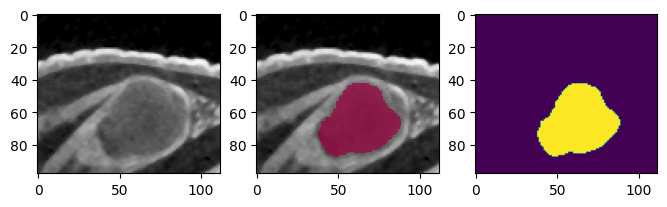

2024-04-04 15:14:33,068 INFO image_writer.py:197 - writing: out/cropped filtered_Patl1_PATTB_E185_male_control_homozygote_26438682f1739e328099bcfb857ac527_RH/cropped filtered_Patl1_PATTB_E185_male_control_homozygote_26438682f1739e328099bcfb857ac527_RH_seg.nii.gz


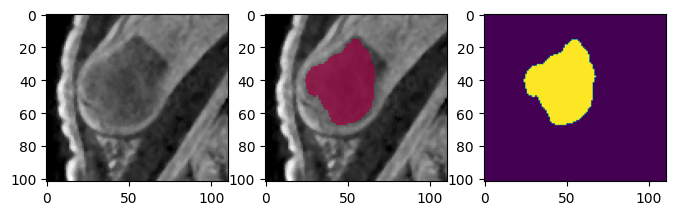

2024-04-04 15:14:33,525 INFO image_writer.py:197 - writing: out/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH/cropped filtered_Piezo2_JR33628_E185_female_experimental_homozygote_b39ed7b3915b9080745cc8df9028b938_RH_seg.nii.gz


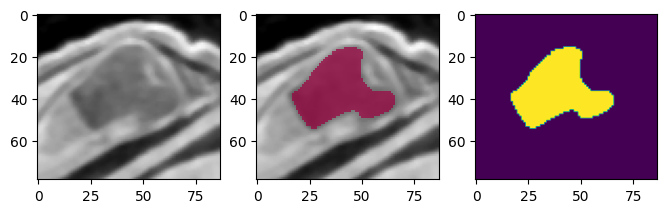

2024-04-04 15:14:34,041 INFO image_writer.py:197 - writing: out/cropped filtered_Zfp414_ZFFFB_E185_female_experimental_homozygote_caa1a267f966579f6dc671d00fe2ab9d_RH/cropped filtered_Zfp414_ZFFFB_E185_female_experimental_homozygote_caa1a267f966579f6dc671d00fe2ab9d_RH_seg.nii.gz


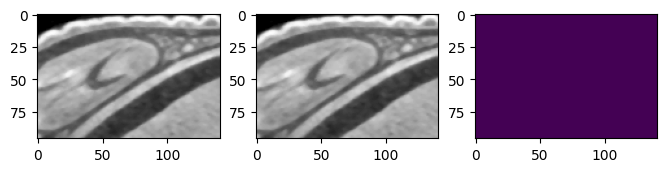

2024-04-04 15:14:34,543 INFO image_writer.py:197 - writing: out/filtered_Lmod3_CR1479_E185_male_control_homozygote_57d0622d18e1bac1a7a7e3d337eebb44_RH/filtered_Lmod3_CR1479_E185_male_control_homozygote_57d0622d18e1bac1a7a7e3d337eebb44_RH_seg.nii.gz


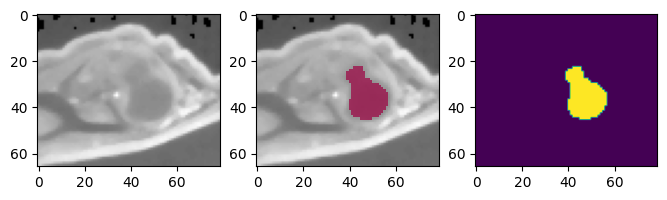

In [3]:
### USER INPUT REQUIRED ###
# Root path to where the data is located
DATA_DIR = "/home/adnanzai/test"
MODEL_NAME = "/home/adnanzai/best_metric_model.pth" # Full path to model pickle file, including name. ex: /home/usr/model.pth
MODEL_CONFIG_FILE = "/home/adnanzai/optuna_config_DiceLoss.yaml" # Full path to model configuration file, This could be the example/model_*.yaml or example/optuna_config.yaml
###
set_determinism(seed=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open(MODEL_CONFIG_FILE, 'r') as stream:
    config = yaml.safe_load(stream)

model_type = config['model']['type']
model = getattr(monai.networks.nets, model_type)(**config['model']['architecture']).to(device)

# Automatically locates the 'imagesTs' folder
test_images = sorted(glob.glob(os.path.join(DATA_DIR, "imagesTs", "*.nii.gz")))
test_data = [{"image": image} for image in test_images]

test_org_transforms = Compose(
    [
        LoadImaged(keys="image"),
        EnsureChannelFirstd(keys="image"),
        ResizeD(keys="image", spatial_size=(256,256,256)),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
    ]
)
post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=test_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
        ),
        AsDiscreted(keys="pred", argmax=True, to_onehot=2),
        SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
    ]
)

# Loads data into the data loader
test_org_ds = Dataset(data=test_data, transform=test_org_transforms)
test_org_loader = ThreadDataLoader(test_org_ds, batch_size=1, num_workers=0)
loader = LoadImage()
model.load_state_dict(torch.load(MODEL_NAME))

model.eval()
with torch.no_grad():
    for test_data in test_org_loader:
        test_inputs = test_data["image"].to(device)
        roi_size = 40 # Adjustable parameter to present overall image dimensions
        sw_batch_size = 4
        slice = 40 # Adjustable parameter (slice to visualize in the plots). Note inference is performed on the entire 3D dataset. 
        test_data["pred"] = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        test_data = [post_transforms(i) for i in decollate_batch(test_data)]

        test_output = from_engine(["pred"])(test_data)

        original_image = loader(test_output[0].meta["filename_or_obj"])

        plt.figure("check", (8,8))
        plt.subplot(1,3,1)
        plt.imshow(original_image[:, :, slice], cmap="gray")

        mask_pred = np.zeros(original_image[:, :, slice].shape)
        mask_pred[test_output[0].detach().cpu()[1, :, :, slice]==1] = 1
        masked_pred = np.ma.masked_where(mask_pred == 0, mask_pred)
        plt.subplot(1, 3, 2)
        plt.imshow(original_image[:, :, slice], cmap="gray")
        plt.imshow(masked_pred, 'Spectral', interpolation='none', alpha=0.7)
        
        plt.subplot(1,3,3)
        plt.imshow(test_output[0].detach().cpu()[1, :, :, slice])

        plt.show()